# Temporal Risk Dynamics

This notebook explores the time-varying risk implementation using an AR(1) autoregressive process, as described in the Healthcare AI Temporal Simulation Framework.

## Key Concepts

1. **Time-Varying Risk**: Patient risk fluctuates due to seasonal patterns, life events, disease progression
2. **AR(1) Process**: Autoregressive model that creates realistic temporal correlations
3. **Bounded Variation**: Risk modifiers kept within realistic bounds [0.5, 2.0]

## Learning Objectives

- Understand how AR(1) processes model temporal risk evolution
- Visualize individual patient risk trajectories over time
- Explore the impact of persistence parameters and noise levels
- Validate that temporal dynamics maintain population-level statistics

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import sys
import os

# Add src directory to path for imports
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), 'src'))

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Import risk assignment function from module
from pop_ml_simulator.risk_distribution import assign_patient_risks
print("Imported risk assignment function from module.")

Imported risk assignment function from module.


## 1. Understanding AR(1) Processes

An AR(1) (first-order autoregressive) process is defined as:
$$X_t = \rho X_{t-1} + (1-\rho)\mu + \epsilon_t$$

Where:
- $\rho$ is the persistence parameter (0 < ρ < 1)
- $\mu$ is the long-term mean (1.0 for our risk modifier)
- $\epsilon_t$ is random noise ~ N(0, σ²)

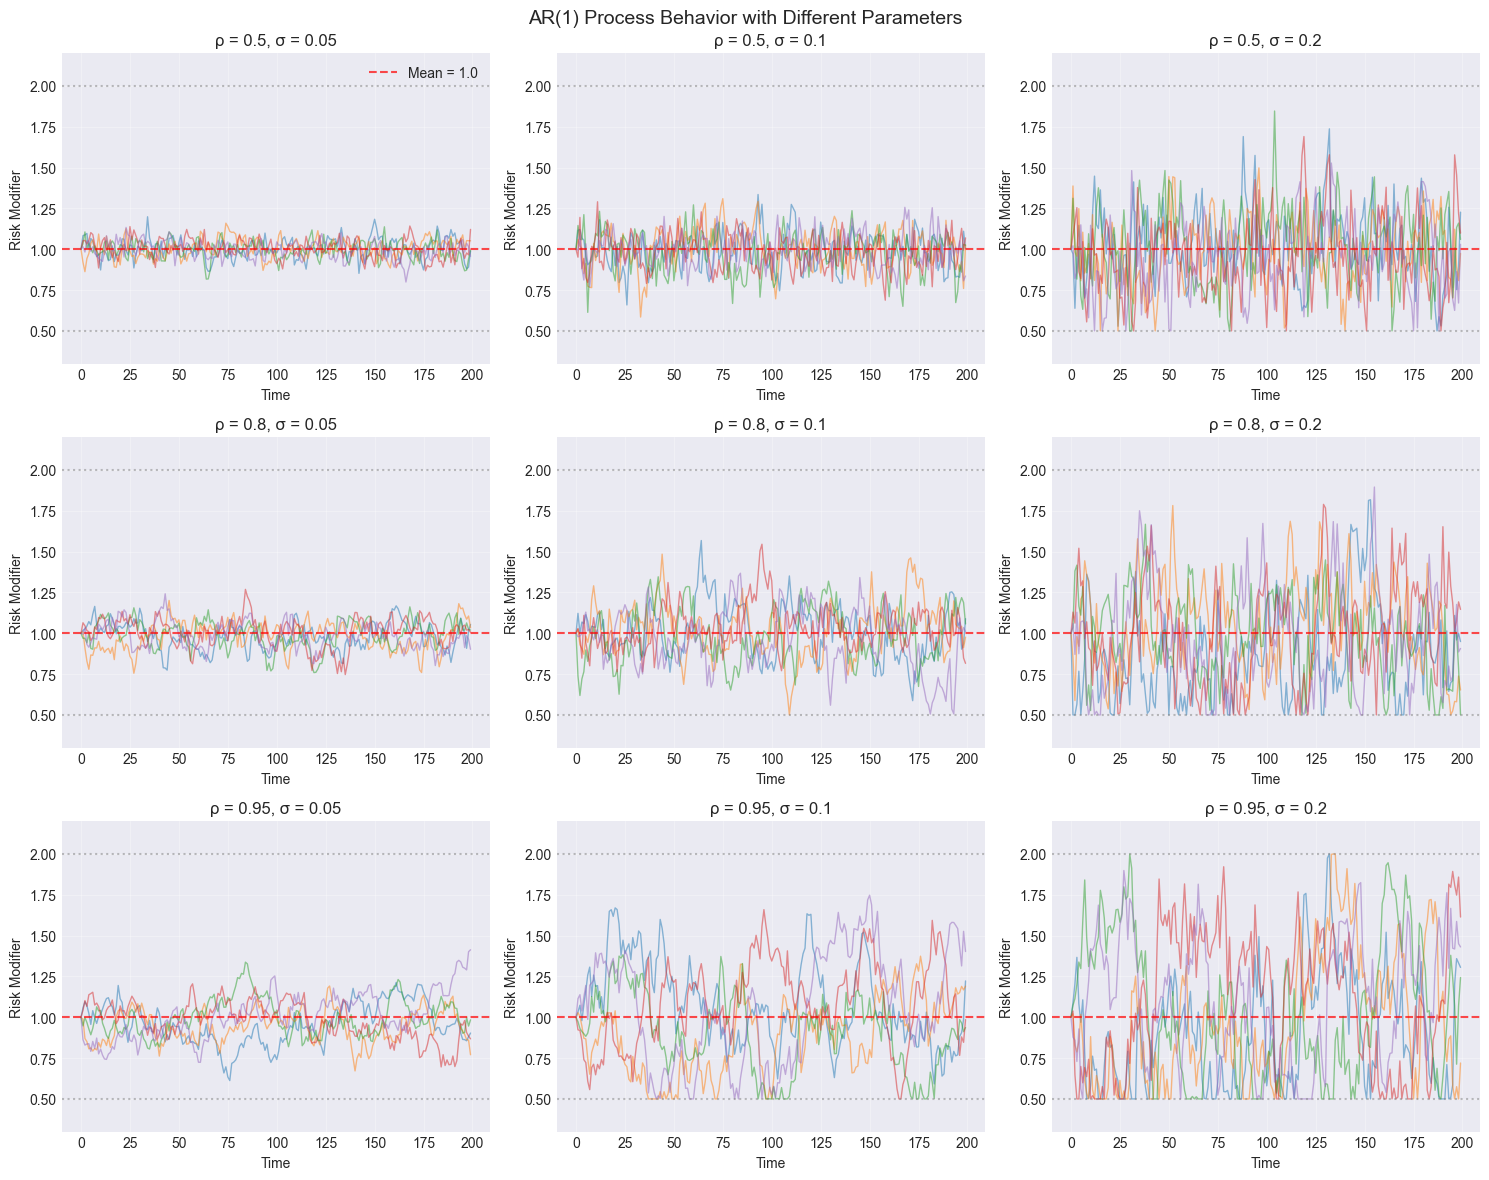

In [3]:
# Import temporal dynamics functions from module
from pop_ml_simulator.temporal_dynamics import simulate_ar1_process

# Demonstrate AR(1) with different parameters
n_timesteps = 200
rhos = [0.5, 0.8, 0.95]
sigmas = [0.05, 0.1, 0.2]

fig, axes = plt.subplots(3, 3, figsize=(15, 12))

for i, rho in enumerate(rhos):
    for j, sigma in enumerate(sigmas):
        ax = axes[i, j]
        
        # Simulate multiple trajectories
        for _ in range(5):
            trajectory = simulate_ar1_process(n_timesteps, rho, sigma, random_seed=np.random.randint(0, 1000))
            ax.plot(trajectory, alpha=0.5, linewidth=1)
        
        # Add mean line
        ax.axhline(1.0, color='red', linestyle='--', alpha=0.7, label='Mean = 1.0')
        ax.axhline(0.5, color='gray', linestyle=':', alpha=0.5)
        ax.axhline(2.0, color='gray', linestyle=':', alpha=0.5)
        
        ax.set_title(f'ρ = {rho}, σ = {sigma}')
        ax.set_xlabel('Time')
        ax.set_ylabel('Risk Modifier')
        ax.set_ylim(0.3, 2.2)
        ax.grid(True, alpha=0.3)
        
        if i == 0 and j == 0:
            ax.legend()

plt.suptitle('AR(1) Process Behavior with Different Parameters', fontsize=14)
plt.tight_layout()
plt.show()

## 2. Temporal Risk Implementation

Now let's implement the full temporal risk system where each patient's risk evolves according to:
$$\text{risk}_i(t) = \text{base\_risk}_i \times \text{temporal\_modifier}_i(t)$$

In [4]:
# Import temporal risk simulator from module
from pop_ml_simulator.temporal_dynamics import TemporalRiskSimulator

# Create a population and simulate temporal dynamics
n_patients = 1000
annual_incident_rate = 0.1
base_risks = assign_patient_risks(n_patients, annual_incident_rate, concentration=0.5)

# Initialize simulator
simulator = TemporalRiskSimulator(base_risks, rho=0.9, sigma=0.1)

# Simulate 52 weeks
n_weeks = 52
simulator.simulate(n_weeks - 1)  # -1 because we start with initial state

# Get histories
modifier_history, risk_history = simulator.get_histories()

print(f"Simulated {n_patients:,} patients over {n_weeks} weeks")
print(f"Shape of risk history: {risk_history.shape}")

Simulated 1,000 patients over 52 weeks
Shape of risk history: (1000, 52)


## 3. Visualizing Individual Patient Trajectories

Let's examine how individual patient risks evolve over time, focusing on patients with different baseline risk levels.

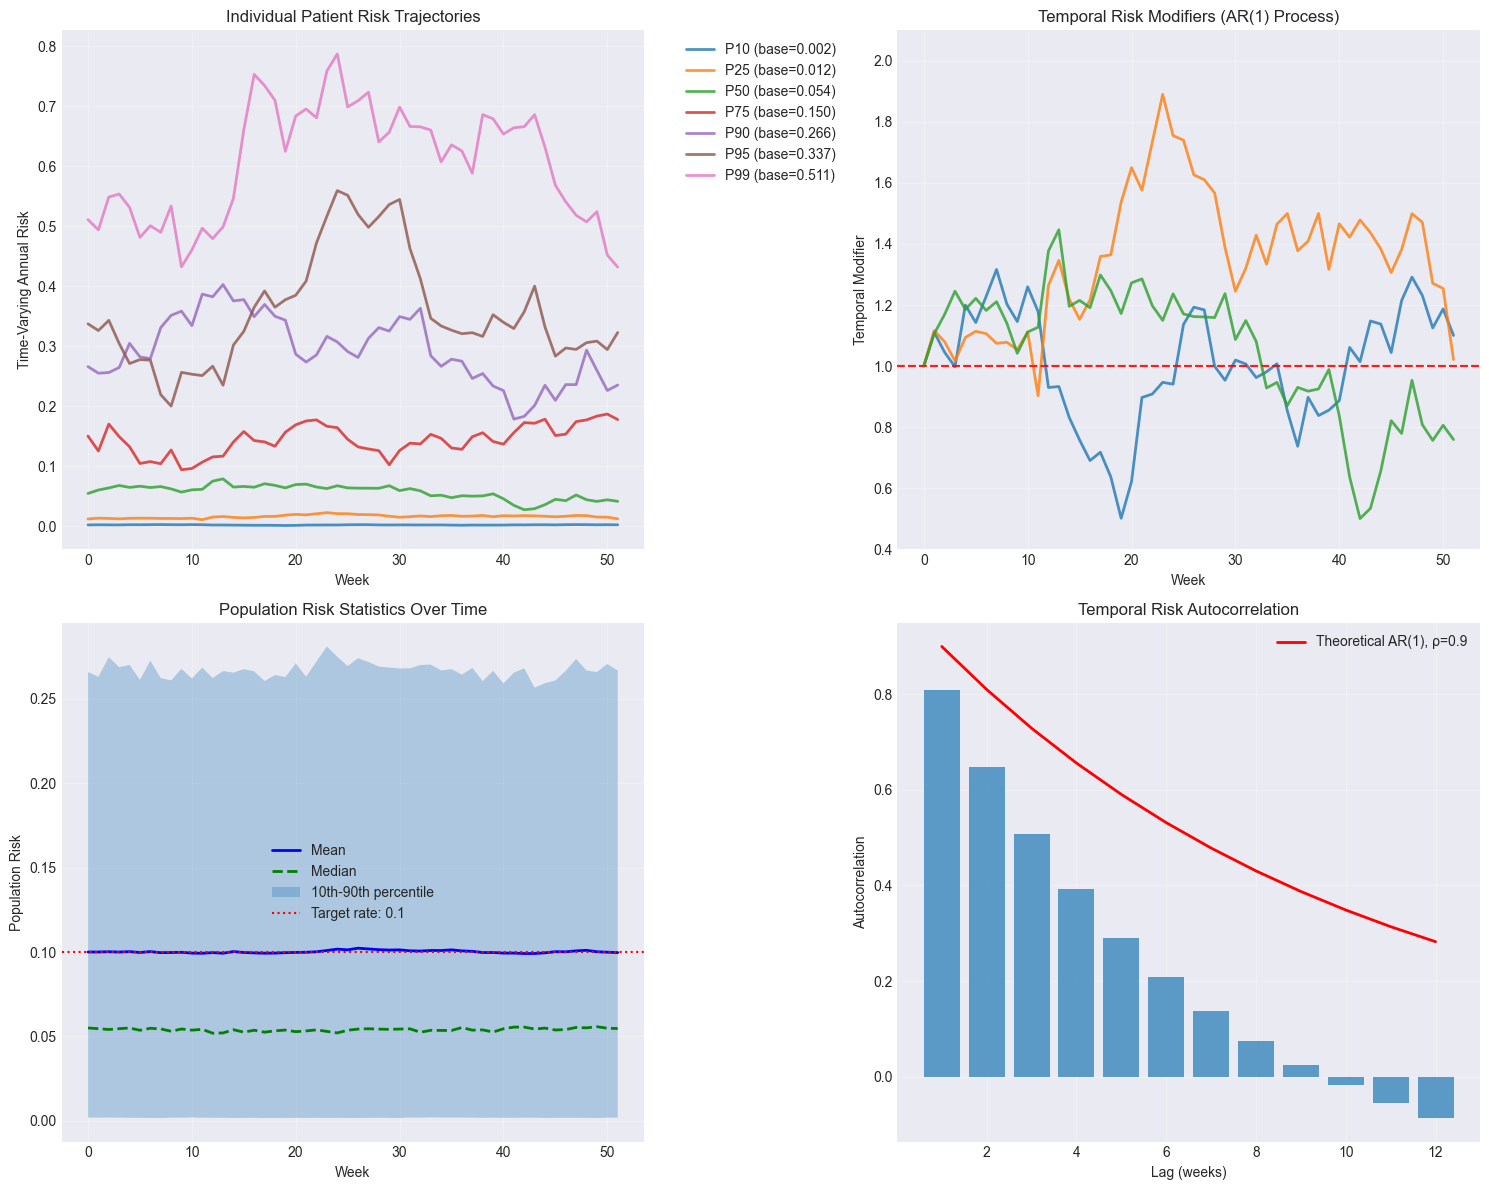

In [5]:
def plot_patient_trajectories(simulator, n_patients_to_plot=20):
    """
    Plot risk trajectories for a selection of patients.
    """
    modifier_history, risk_history = simulator.get_histories()
    
    # Select patients across risk spectrum
    risk_percentiles = [10, 25, 50, 75, 90, 95, 99]
    selected_indices = []
    
    for p in risk_percentiles:
        idx = np.argmin(np.abs(simulator.base_risks - np.percentile(simulator.base_risks, p)))
        selected_indices.append(idx)
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Individual trajectories
    ax = axes[0, 0]
    for i, idx in enumerate(selected_indices):
        base_risk = simulator.base_risks[idx]
        trajectory = risk_history[idx]
        percentile = risk_percentiles[i]
        
        ax.plot(trajectory, linewidth=2, 
                label=f'P{percentile} (base={base_risk:.3f})',
                alpha=0.8)
    
    ax.set_xlabel('Week')
    ax.set_ylabel('Time-Varying Annual Risk')
    ax.set_title('Individual Patient Risk Trajectories')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    
    # 2. Temporal modifiers only
    ax = axes[0, 1]
    for i, idx in enumerate(selected_indices[:3]):  # Just show a few
        modifier_trajectory = modifier_history[idx]
        ax.plot(modifier_trajectory, linewidth=2, alpha=0.8)
        
        # Add base risk as horizontal line
        ax.axhline(1.0, color='red', linestyle='--', alpha=0.5)
    
    ax.set_xlabel('Week')
    ax.set_ylabel('Temporal Modifier')
    ax.set_title('Temporal Risk Modifiers (AR(1) Process)')
    ax.set_ylim(0.4, 2.1)
    ax.grid(True, alpha=0.3)
    
    # 3. Population statistics over time
    ax = axes[1, 0]
    
    # Calculate population statistics at each time point
    mean_risks = np.mean(risk_history, axis=0)
    median_risks = np.median(risk_history, axis=0)
    p10_risks = np.percentile(risk_history, 10, axis=0)
    p90_risks = np.percentile(risk_history, 90, axis=0)
    
    weeks = np.arange(len(mean_risks))
    
    ax.plot(weeks, mean_risks, 'b-', linewidth=2, label='Mean')
    ax.plot(weeks, median_risks, 'g--', linewidth=2, label='Median')
    ax.fill_between(weeks, p10_risks, p90_risks, alpha=0.3, 
                    label='10th-90th percentile')
    
    # Add target line
    ax.axhline(annual_incident_rate, color='red', linestyle=':', 
               label=f'Target rate: {annual_incident_rate}')
    
    ax.set_xlabel('Week')
    ax.set_ylabel('Population Risk')
    ax.set_title('Population Risk Statistics Over Time')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 4. Risk correlation analysis
    ax = axes[1, 1]
    
    # Calculate autocorrelation of risks
    lags = range(1, 13)  # Up to 12 weeks lag
    autocorr_values = []
    
    for lag in lags:
        # For each patient, calculate correlation between risk at t and t-lag
        correlations = []
        for patient_risks in risk_history:
            if len(patient_risks) > lag:
                corr = np.corrcoef(patient_risks[:-lag], patient_risks[lag:])[0, 1]
                correlations.append(corr)
        autocorr_values.append(np.mean(correlations))
    
    ax.bar(lags, autocorr_values, alpha=0.7)
    
    # Add theoretical AR(1) autocorrelation
    theoretical_autocorr = [simulator.rho**lag for lag in lags]
    ax.plot(lags, theoretical_autocorr, 'r-', linewidth=2, 
            label=f'Theoretical AR(1), ρ={simulator.rho}')
    
    ax.set_xlabel('Lag (weeks)')
    ax.set_ylabel('Autocorrelation')
    ax.set_title('Temporal Risk Autocorrelation')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_patient_trajectories(simulator)

## 4. Impact of AR(1) Parameters

Let's systematically explore how different persistence (ρ) and noise (σ) parameters affect the temporal dynamics.

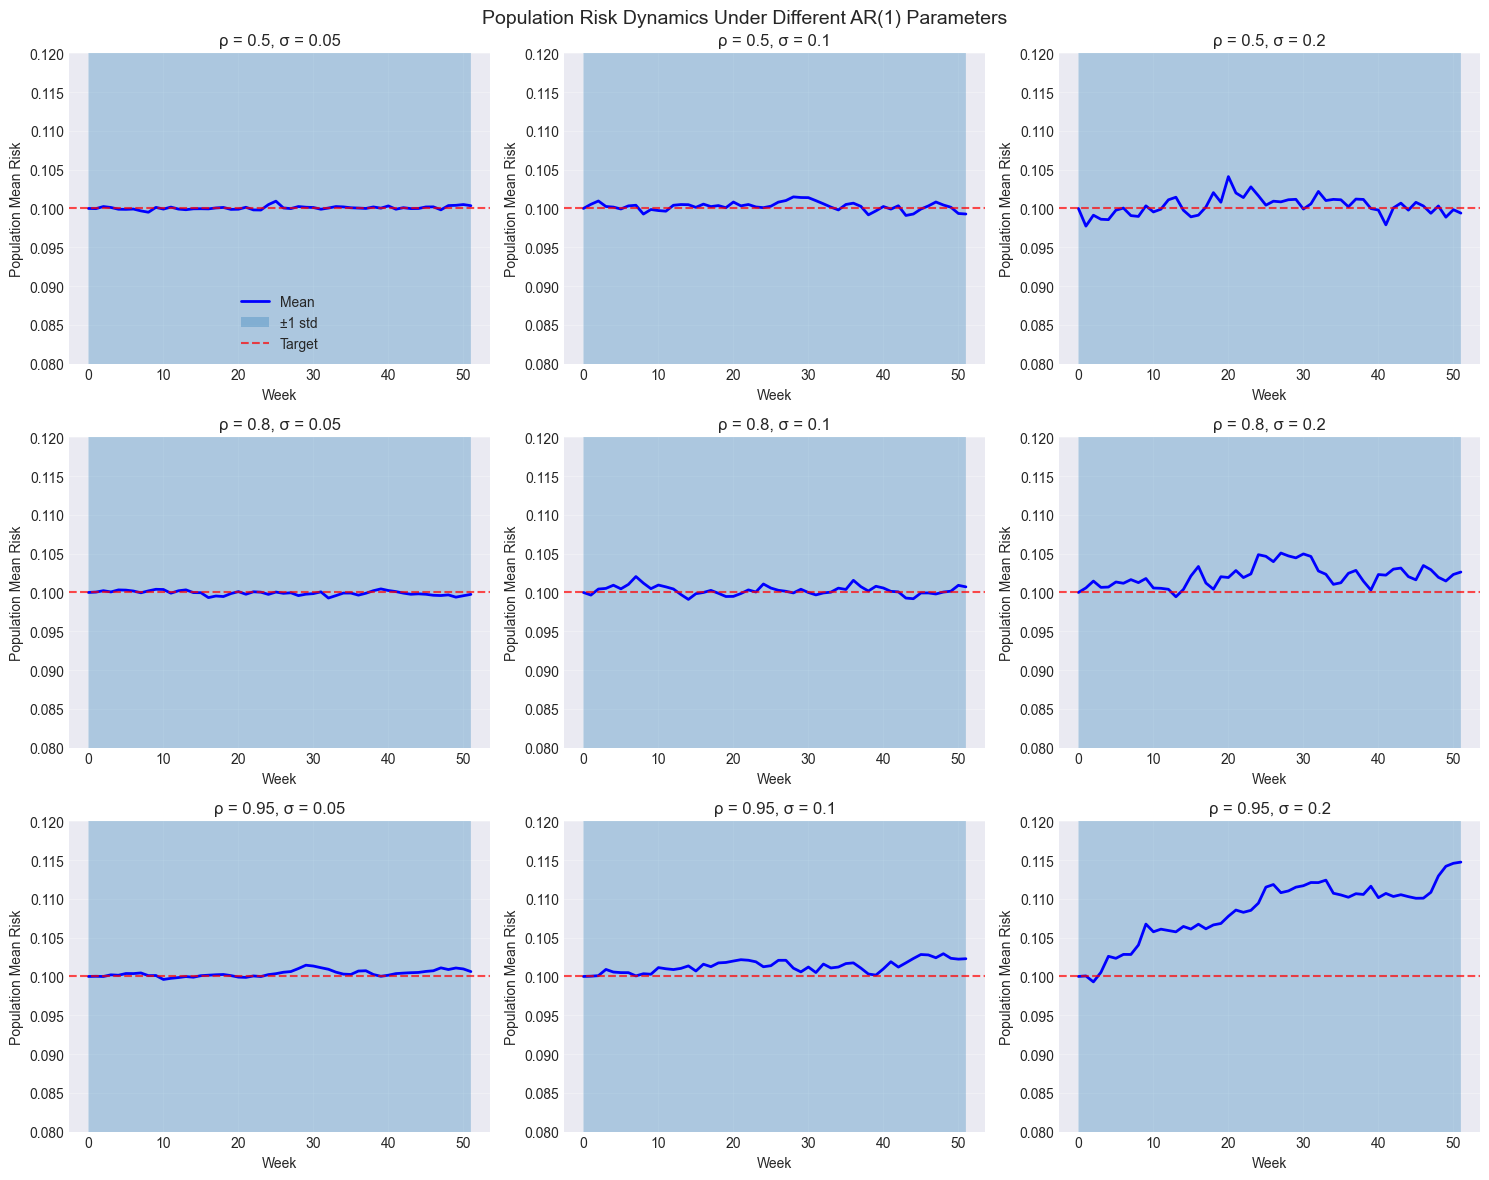


Parameter Impact Summary:
    rho  sigma  modifier_variance  risk_cv  memory_weeks  mean_preservation
0  0.50   0.05             0.0032   1.1925             1             0.0001
1  0.50   0.10             0.0128   1.2038             2             0.0003
2  0.50   0.20             0.0497   1.2375             1             0.0003
3  0.80   0.05             0.0066   1.1936             3             0.0001
4  0.80   0.10             0.0263   1.2092             3             0.0003
5  0.80   0.20             0.0894   1.2615             1             0.0021
6  0.95   0.05             0.0203   1.2136             6             0.0004
7  0.95   0.10             0.0712   1.2411             2             0.0013
8  0.95   0.20             0.1694   1.3124             3             0.0084


In [6]:
def analyze_parameter_impact(base_risks, n_weeks=52):
    """
    Analyze impact of different AR(1) parameters on risk dynamics.
    """
    rho_values = [0.5, 0.8, 0.95]
    sigma_values = [0.05, 0.1, 0.2]
    
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    
    results = []
    
    for i, rho in enumerate(rho_values):
        for j, sigma in enumerate(sigma_values):
            ax = axes[i, j]
            
            # Run simulation
            sim = TemporalRiskSimulator(base_risks, rho=rho, sigma=sigma)
            sim.simulate(n_weeks - 1)
            
            modifier_hist, risk_hist = sim.get_histories()
            
            # Calculate statistics
            mean_risk_over_time = np.mean(risk_hist, axis=0)
            std_risk_over_time = np.std(risk_hist, axis=0)
            
            # Plot mean and std bands
            weeks = np.arange(n_weeks)
            ax.plot(weeks, mean_risk_over_time, 'b-', linewidth=2, label='Mean')
            ax.fill_between(weeks, 
                           mean_risk_over_time - std_risk_over_time,
                           mean_risk_over_time + std_risk_over_time,
                           alpha=0.3, label='±1 std')
            
            # Add target line
            ax.axhline(np.mean(base_risks), color='red', linestyle='--', 
                      alpha=0.7, label='Target')
            
            ax.set_title(f'ρ = {rho}, σ = {sigma}')
            ax.set_xlabel('Week')
            ax.set_ylabel('Population Mean Risk')
            ax.set_ylim(0.08, 0.12)
            ax.grid(True, alpha=0.3)
            
            if i == 0 and j == 0:
                ax.legend()
            
            # Calculate summary statistics
            modifier_variance = np.var(modifier_hist)
            risk_cv = np.std(risk_hist) / np.mean(risk_hist)  # Coefficient of variation
            
            # Calculate "memory" - how long effects persist
            # Find lag where autocorrelation drops below 0.5
            patient_0_modifiers = modifier_hist[0]
            autocorr = [1.0]
            for lag in range(1, min(20, n_weeks)):
                if len(patient_0_modifiers) > lag:
                    corr = np.corrcoef(patient_0_modifiers[:-lag], 
                                      patient_0_modifiers[lag:])[0, 1]
                    autocorr.append(corr)
                    if corr < 0.5:
                        memory_weeks = lag
                        break
            else:
                memory_weeks = 20
            
            results.append({
                'rho': rho,
                'sigma': sigma,
                'modifier_variance': modifier_variance,
                'risk_cv': risk_cv,
                'memory_weeks': memory_weeks,
                'mean_preservation': np.abs(np.mean(risk_hist) - np.mean(base_risks))
            })
    
    plt.suptitle('Population Risk Dynamics Under Different AR(1) Parameters', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Display summary table
    df_results = pd.DataFrame(results)
    print("\nParameter Impact Summary:")
    print(df_results.round(4))
    
    return df_results

results_df = analyze_parameter_impact(base_risks)

## 5. Seasonal and Shock Effects

The AR(1) framework can be extended to include seasonal patterns and external shocks (e.g., flu season, COVID waves).

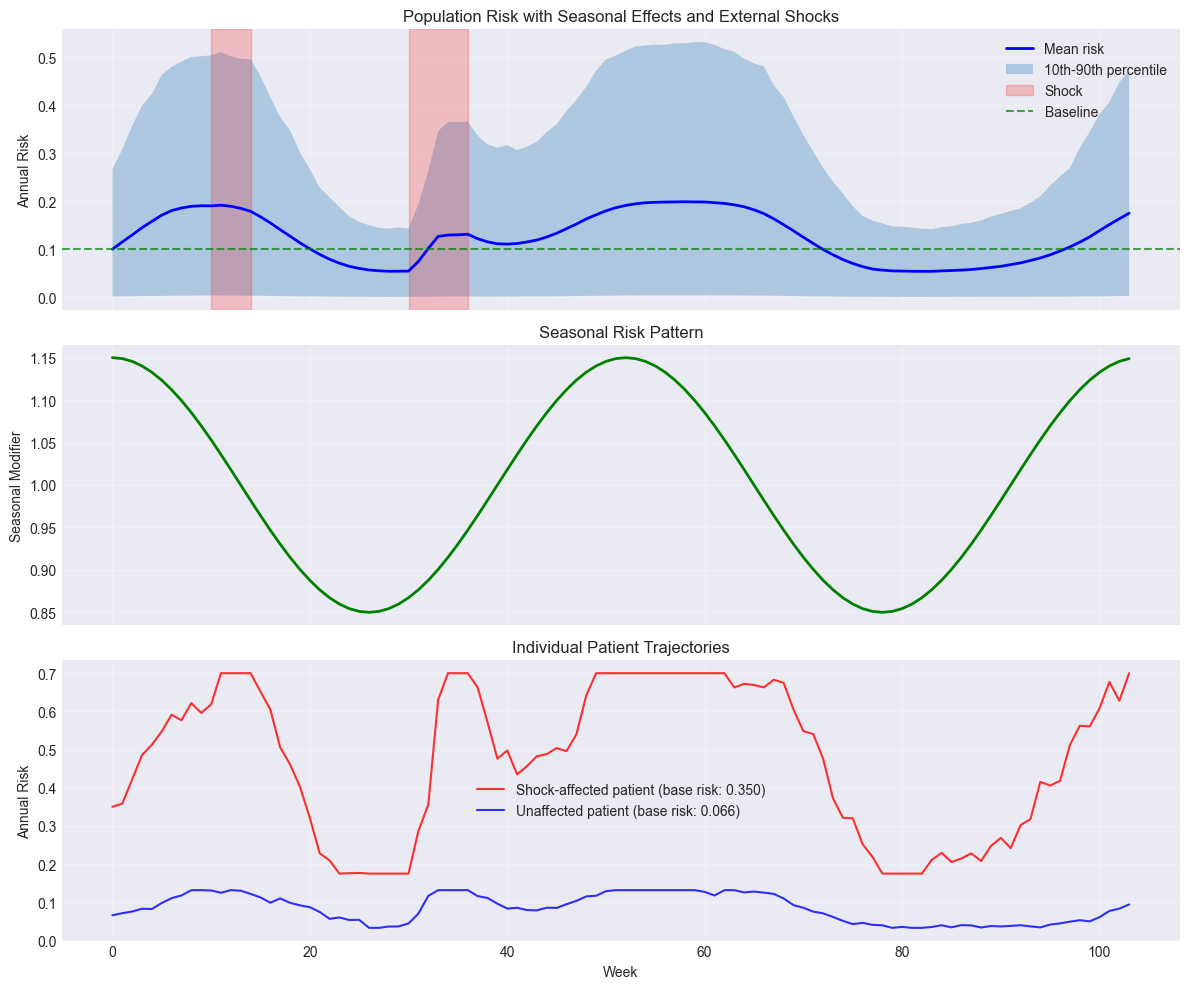

In [7]:
# Import enhanced temporal risk simulator from module
from pop_ml_simulator.temporal_dynamics import EnhancedTemporalRiskSimulator

# Demonstrate enhanced simulator
enhanced_sim = EnhancedTemporalRiskSimulator(base_risks, rho=0.9, sigma=0.1,
                                             seasonal_amplitude=0.15)

# Add some shocks
enhanced_sim.add_shock(time_step=10, magnitude=1.5, duration=4, affected_fraction=0.3)
enhanced_sim.add_shock(time_step=30, magnitude=1.8, duration=6, affected_fraction=0.5)

# Simulate 104 weeks (2 years)
n_weeks = 104
enhanced_sim.simulate(n_weeks - 1)

# Visualize results
modifier_hist, risk_hist = enhanced_sim.get_histories()

fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# 1. Population mean risk over time
ax = axes[0]
mean_risk = np.mean(risk_hist, axis=0)
p10_risk = np.percentile(risk_hist, 10, axis=0)
p90_risk = np.percentile(risk_hist, 90, axis=0)

weeks = np.arange(len(mean_risk))
ax.plot(weeks, mean_risk, 'b-', linewidth=2, label='Mean risk')
ax.fill_between(weeks, p10_risk, p90_risk, alpha=0.3, label='10th-90th percentile')

# Mark shocks
for shock in enhanced_sim.external_shocks:
    ax.axvspan(shock['time'], shock['time'] + shock['duration'], 
               alpha=0.2, color='red', label='Shock' if shock == enhanced_sim.external_shocks[0] else '')

ax.axhline(np.mean(base_risks), color='green', linestyle='--', alpha=0.7, label='Baseline')
ax.set_ylabel('Annual Risk')
ax.set_title('Population Risk with Seasonal Effects and External Shocks')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Seasonal component
ax = axes[1]
seasonal_component = [1.0 + enhanced_sim.seasonal_amplitude * 
                     np.sin(2 * np.pi * t / enhanced_sim.seasonal_period + np.pi/2) 
                     for t in range(len(mean_risk))]
ax.plot(weeks, seasonal_component, 'g-', linewidth=2)
ax.set_ylabel('Seasonal Modifier')
ax.set_title('Seasonal Risk Pattern')
ax.grid(True, alpha=0.3)

# 3. Sample individual trajectories
ax = axes[2]
# Select patients: some affected by shocks, some not
affected_patient = enhanced_sim.external_shocks[0]['affected_patients'][0]
unaffected_patient = np.setdiff1d(range(enhanced_sim.n_patients), 
                                  enhanced_sim.external_shocks[0]['affected_patients'])[0]

ax.plot(weeks, risk_hist[affected_patient], 'r-', alpha=0.8, 
        label=f'Shock-affected patient (base risk: {base_risks[affected_patient]:.3f})')
ax.plot(weeks, risk_hist[unaffected_patient], 'b-', alpha=0.8,
        label=f'Unaffected patient (base risk: {base_risks[unaffected_patient]:.3f})')

ax.set_xlabel('Week')
ax.set_ylabel('Annual Risk')
ax.set_title('Individual Patient Trajectories')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Validation: Temporal Properties

Let's validate that our temporal risk implementation maintains the desired statistical properties.

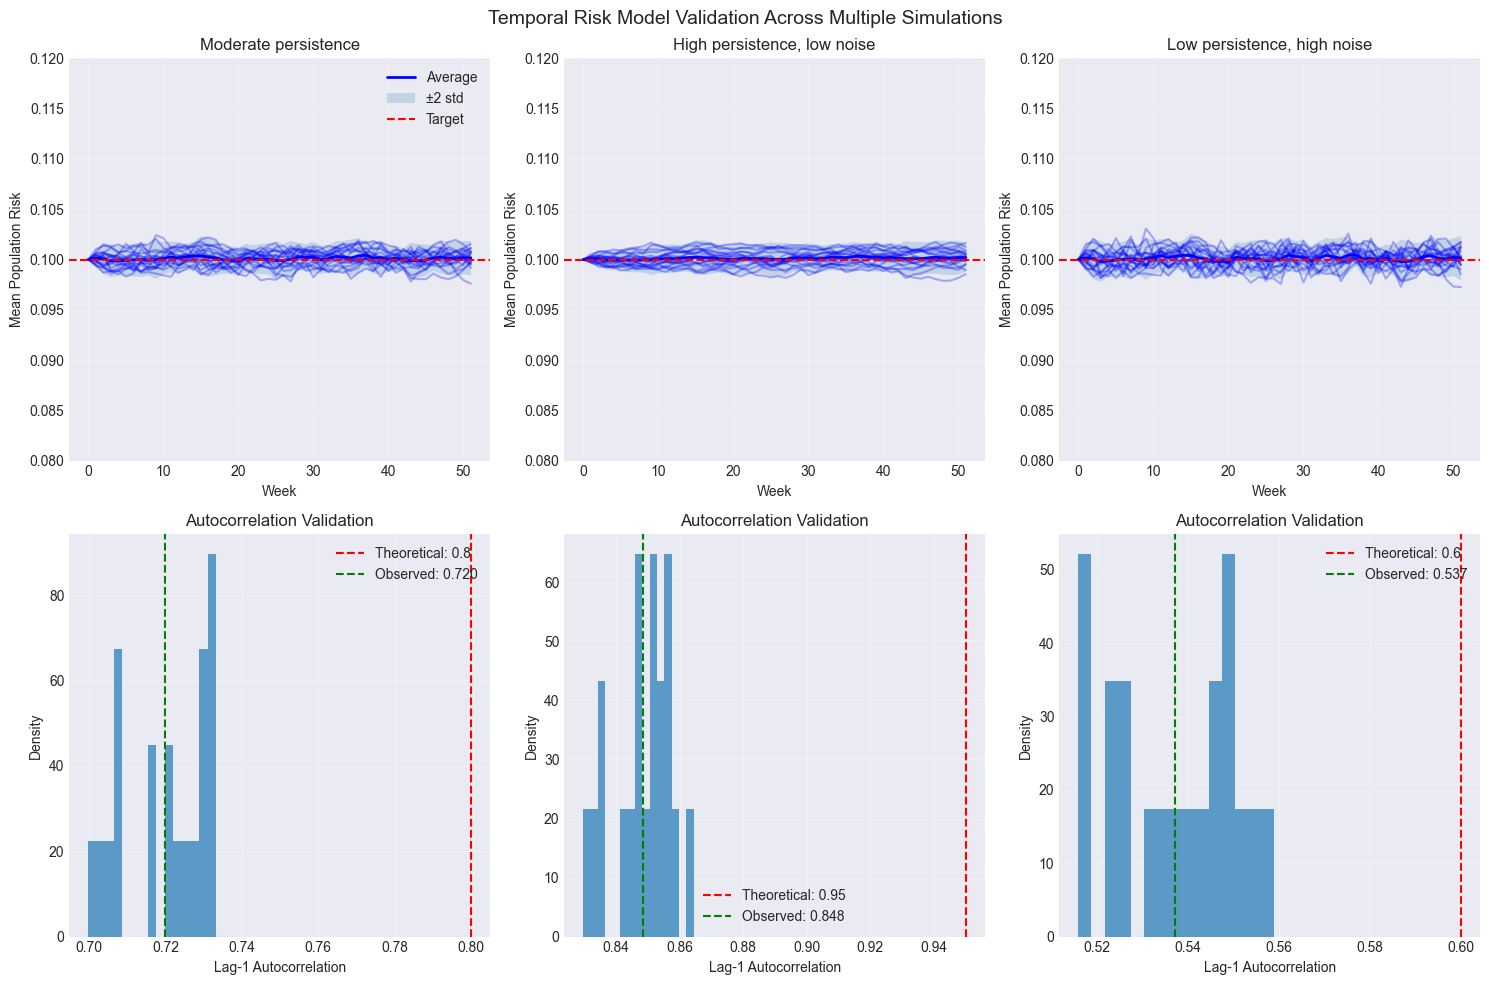

In [8]:
def validate_temporal_properties(n_simulations=20, n_weeks=52):
    """
    Run multiple simulations to validate temporal properties.
    """
    # Test different parameter combinations
    test_configs = [
        {'rho': 0.8, 'sigma': 0.1, 'name': 'Moderate persistence'},
        {'rho': 0.95, 'sigma': 0.05, 'name': 'High persistence, low noise'},
        {'rho': 0.6, 'sigma': 0.15, 'name': 'Low persistence, high noise'}
    ]
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    for col, config in enumerate(test_configs):
        all_mean_risks = []
        all_autocorr = []
        
        for sim_idx in range(n_simulations):
            # Create new population each time
            base_risks = assign_patient_risks(1000, 0.1, concentration=0.5, 
                                            random_seed=42 + sim_idx)
            
            # Run simulation
            sim = TemporalRiskSimulator(base_risks, 
                                       rho=config['rho'], 
                                       sigma=config['sigma'])
            sim.simulate(n_weeks - 1)
            
            _, risk_hist = sim.get_histories()
            
            # Track mean risk over time
            mean_risk_trajectory = np.mean(risk_hist, axis=0)
            all_mean_risks.append(mean_risk_trajectory)
            
            # Calculate autocorrelation at lag 1
            patient_autocorr = []
            for patient_risks in risk_hist[:100]:  # Sample of patients
                if len(patient_risks) > 1:
                    corr = np.corrcoef(patient_risks[:-1], patient_risks[1:])[0, 1]
                    patient_autocorr.append(corr)
            all_autocorr.append(np.mean(patient_autocorr))
        
        # Plot 1: Mean risk trajectories
        ax = axes[0, col]
        all_mean_risks = np.array(all_mean_risks)
        
        # Plot individual runs
        for trajectory in all_mean_risks:
            ax.plot(trajectory, alpha=0.3, color='blue')
        
        # Plot average and bounds
        avg_trajectory = np.mean(all_mean_risks, axis=0)
        std_trajectory = np.std(all_mean_risks, axis=0)
        
        ax.plot(avg_trajectory, 'b-', linewidth=2, label='Average')
        ax.fill_between(range(len(avg_trajectory)),
                       avg_trajectory - 2*std_trajectory,
                       avg_trajectory + 2*std_trajectory,
                       alpha=0.2, label='±2 std')
        
        ax.axhline(0.1, color='red', linestyle='--', label='Target')
        ax.set_xlabel('Week')
        ax.set_ylabel('Mean Population Risk')
        ax.set_title(config['name'])
        ax.set_ylim(0.08, 0.12)
        if col == 0:
            ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Plot 2: Autocorrelation distribution
        ax = axes[1, col]
        ax.hist(all_autocorr, bins=15, alpha=0.7, density=True)
        ax.axvline(config['rho'], color='red', linestyle='--', 
                  label=f"Theoretical: {config['rho']}")
        ax.axvline(np.mean(all_autocorr), color='green', linestyle='--',
                  label=f"Observed: {np.mean(all_autocorr):.3f}")
        ax.set_xlabel('Lag-1 Autocorrelation')
        ax.set_ylabel('Density')
        ax.set_title('Autocorrelation Validation')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('Temporal Risk Model Validation Across Multiple Simulations', fontsize=14)
    plt.tight_layout()
    plt.show()
    
validate_temporal_properties()

## 7. Key Insights and Implications

### AR(1) Process Benefits

1. **Realistic Persistence**: Patient risk doesn't change randomly each period
2. **Tunable Memory**: ρ parameter controls how long risk elevations persist
3. **Bounded Variation**: Keeps risk within clinically plausible ranges
4. **Mathematical Tractability**: Well-understood statistical properties

### Parameter Selection Guidelines

- **ρ = 0.8-0.9**: Moderate persistence, suitable for chronic conditions
- **ρ = 0.95+**: High persistence, for slowly evolving risks
- **σ = 0.05-0.1**: Low noise, stable risk profiles
- **σ = 0.15-0.2**: Higher variability, acute condition risks

### Practical Implications

1. **Prediction Windows**: Temporal correlation affects optimal prediction horizons
2. **Intervention Timing**: Risk persistence influences when to reassess patients
3. **Model Retraining**: Temporal dynamics suggest update frequencies
4. **Causal Inference**: Time-varying confounders require careful handling

### Extensions Demonstrated

1. **Seasonal Effects**: Captures known healthcare patterns (flu season, etc.)
2. **External Shocks**: Models pandemic effects, system disruptions
3. **Heterogeneous Effects**: Different patients respond differently to shocks